In [1]:
import os

import joblib
from tpot.config import regressor_config_dict

os.environ['OPENBLAS_NUM_THREADS'] = '1'

import sklearn.model_selection
import sklearn.metrics
import numpy as np
import pandas as pd
import tpot
from joblib import dump, load
from verstack.stratified_continuous_split import scsplit
import matplotlib.pyplot as plt
import time as time
import datetime as datetime

if __name__ == "__main__":
    hours = 4
    time_mins = hours * 60
    target_feature = "eventRateOut"
    filename = "yahoo_geni_15s_combined_samples.csv"

    selected_features_throughput = ["Relaxation", "Rizou", "ProducerConsumer", "Random", "GlobalOptimalBDP", "MDCEP",
                                    "operatorSelectivity", "eventRateIn", "processingLatencyMean", "processingLatencyStdDev"]
    selected_features_processing_latency = ["Relaxation", "Rizou", "ProducerConsumer", "Random", "GlobalOptimalBDP", "MDCEP",
                                            "eventSizeInKB", "operatorSelectivity", "interArrivalMean", "interArrivalStdDev",
                                            "brokerCPULoad", "eventRateOut"]

    selected_dict = { "eventRateOut" : selected_features_throughput, "processingLatencyMean" : selected_features_processing_latency}


    f = open(filename)
    df = pd.read_csv(f, sep=";", header=0)
    f.close()
    df = df._get_numeric_data()

    start_time = time.time()
    print("starting training at ", datetime.datetime.now().strftime('%H:%M:%S'))
    X, y = df[selected_dict[target_feature]], df[target_feature]
    #train, valid = scsplit(df, df['continuous_column_name])
    #X_train, X_test, y_train, y_test = scsplit(X, y, stratify = y)
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, shuffle=True)

    #configure settings
    # dask: avoid refitting same estimator on same data split if it has been fit before
    # memory: If supplied, pipeline will cache each transformer after calling fit. This feature
    #   is used to avoid computing the fit transformers within a pipeline if the parameters
    #   and input data are identical with another fitted pipeline during optimization process.
    regressor_config_dict.pop('sklearn.linear_model.LassoLarsCV') # remove since we suspect it to overfit

    automl = tpot.TPOTRegressor(
        config_dict=regressor_config_dict,
        memory='auto',
        subsample=1.0,
        max_time_mins=time_mins, # total time
        max_eval_time_mins=8, # default 5; time per pipeline
        generations=100, population_size=100, verbosity=3, n_jobs=-1)

    #run TPOT
    automl.fit(X_train, y_train)
    end_time = time.time()
    predictions = automl.predict(X_test)
    print("finished after ", end_time - start_time)

/home/niels/PycharmProjects/pythonProject/venv/lib/python3.7/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")


starting training at  02:44:04
30 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/40 [00:00<?, ?pipeline/s]

Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.

Generation 1 - Current Pareto front scores:

-1	-882.4234990436286	RandomForestRegressor(input_matrix, RandomForestRegressor__bootstrap=False, RandomForestRegressor__max_features=1.0, RandomForestRegressor__min_samples_leaf=7, RandomForestRegressor__min_samples_split=7, RandomForestRegressor__n_estimators=100)
finished after  11.55465024


In [ ]:
    model_name = 'output/tpot_trained_pipeline_' + str(hours) + '_' + filename + '_' + target_feature + '.joblib'    #persist the trained pipeline
    dump(automl.fitted_pipeline_, model_name)
    automl.export('tpot_pipeline.py')

In [ ]:
    print("pareto_front: \n", automl.pareto_front_fitted_pipelines_)
    # best model
    best_model = automl.fitted_pipeline_.steps[-1][1]
    print(best_model)
    # Train best_model on ENTIRE dataset to get feature importance
    best_model.fit(X, y)
    # feature importances
    print(best_model.feature_importances_)

    # Plot as barplot
    positions= range(best_model.feature_importances_.shape[0])
    plt.bar(positions, best_model.feature_importances_)
    plt.show()

In [1]:
    print(automl.fitted_pipeline_)
    print("\n\n#######\noptimized metric: ", automl.scoring_function)
    #print(automl.score(X_test, y_test))
    # test loading persisted model
    fitted_pipeline_restored = joblib.load(model_name)
    predictions = fitted_pipeline_restored.predict(X_test)
    
    mse = sklearn.metrics.mean_squared_error(y_test, predictions)
    rmse = mse ** 0.5
    mae = sklearn.metrics.mean_absolute_error(y_test, predictions)
    mae_percentage = sklearn.metrics.mean_absolute_percentage_error(y_test, predictions)
    median_ae =  sklearn.metrics.median_absolute_error(y_test, predictions)
    r2 = sklearn.metrics.r2_score(y_test, predictions)
    
    print("r2 score:{}".format(r2))
    print("mean squared error: ", mse)
    print("root mean squared error: ", rmse)
    print("mean absolute error: ", mae)
    print("median absolute error: ", median_ae)
    print("mean absolute percentage error: ", mae_percentage)
    print("explained variance score: ", sklearn.metrics.explained_variance_score(y_test, predictions))
    
    with open('tpot_' + str(hours) + 'h_' + filename + '_' + target_feature + '_scores.csv', 'w') as sc:
        sc.write('framework,training_time,target_metric,RMSE,MSE,MAE,mean_abs_percentage_error,median_abs_error,r2,pipeline\n')
        sc.write('tpot,' + str(hours) + ',' + target_feature + ',' + str(rmse) + ',' + str(mse) + ',' + str(mae) + ','
                 + str(mae_percentage) + ',' + str(median_ae) + ',' + str(r2) + ',' + str(best_model))

NameError: name 'automl' is not defined

1728 1728


Text(0.5, 0, 'Time')

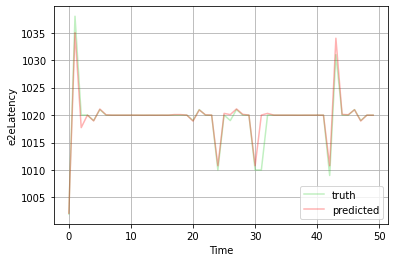

In [3]:

    print(len(y_test), len(predictions))
    plt.plot(y_test.to_numpy()[:50], alpha=0.3, label="truth", color="limegreen")
    plt.plot(predictions[:50], alpha=0.3, label="predicted", color="red")
    #plt.semilogy()
    plt.grid()
    plt.legend()
    plt.ylabel("e2eLatency")
    plt.xlabel("Time")

In [ ]:
    import PipelineProfiler

    PipelineProfiler.plot_pipeline_matrix(fitted_pipeline_restored)

In [2]:

'''
    import joblib
    # test loading persisted model
    fitted_pipeline_restored = joblib.load('output/tpot_trained_pipeline_8_yahoo_geni_5s_combined_samples.csv_eventRateOut.joblib')
    #import pickle
    #pickle.dump(automl.fitted_pipeline_, open(filename, 'wb'))
    #fitted_pipeline_restored = pickle.load(open(filename))
    predictions = fitted_pipeline_restored.predict(X_test)
    import sklearn.metrics
    import sklearn.model_selection
    import numpy as np
    import pandas as pd
    hours = 8
    time_mins = hours * 60
    target_feature = "eventRateOut"
    filename = "yahoo_geni_5s_combined_samples.csv"

    selected_features_throughput = ["Relaxation", "Rizou", "ProducerConsumer", "Random", "GlobalOptimalBDP", "MDCEP",
                                    "operatorSelectivity", "eventRateIn", "processingLatencyMean", "processingLatencyStdDev"]
    selected_features_processing_latency = ["Relaxation", "Rizou", "ProducerConsumer", "Random", "GlobalOptimalBDP", "MDCEP",
                                            "eventSizeInKB", "operatorSelectivity", "interArrivalMean", "interArrivalStdDev",
                                            "brokerCPULoad", "eventRateOut"]

    selected_dict = { "eventRateOut" : selected_features_throughput, "processingLatencyMean" : selected_features_processing_latency}


    f = open('../../../../' + filename)
    df = pd.read_csv(f, sep=";", header=0)
    f.close()
    df = df._get_numeric_data()

    X, y = df[selected_dict[target_feature]], df[target_feature]
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, shuffle=True)
    mse = sklearn.metrics.mean_squared_error(y_test, predictions)
    rmse = mse ** 0.5
    mae = sklearn.metrics.mean_absolute_error(y_test, predictions)
    mae_percentage = sklearn.metrics.mean_absolute_percentage_error(y_test, predictions)
    median_ae =  sklearn.metrics.median_absolute_error(y_test, predictions)
    r2 = sklearn.metrics.r2_score(y_test, predictions)

    print("r2 score:{}".format(r2))
    print("mean squared error: ", mse)
    print("root mean squared error: ", rmse)
    print("mean absolute error: ", mae)
    print("median absolute error: ", median_ae)
    print("mean absolute percentage error: ", mae_percentage)
    print("explained variance score: ", sklearn.metrics.explained_variance_score(y_test, predictions))

    with open('tpot_' + str(hours) + 'h_' + filename + '_' + target_feature + '_scores.csv', 'w') as sc:
        sc.write('framework,training_time,target_metric,RMSE,MSE,MAE,mean_abs_percentage_error,median_abs_error,r2\n')
        sc.write('tpot,' + str(hours) + ',' + target_feature + ',' + str(rmse) + ',' + str(mse) + ',' + str(mae) + ',' + str(mae_percentage) + ',' + str(median_ae) + ',' + str(r2))
'''

FileNotFoundError: [Errno 2] No such file or directory: 'output/tpot_trained_pipeline_8_yahoo_geni_5s_combined_samples.csv_eventRateOut.joblib'